In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# Parameters for simulation
chromatine_size = 60
polymerase_count = 0
simulation_steps = 150
adding_position = 15
end_of_replication_position = chromatine_size - 15

# Simulation-specific parameters
histone_modification_percentage = 0.3
recruitment_probability = 1
change_probability = 0.3
regeneration_probability = 0.3
adding_polymerase_probability = 0.3
vicinity_size = 5

# Linear function parameters
slope = 1e-5
intercept = 1e-1

# Polymerase movement probabilities
left_movement_probability = 1/2
right_movement_probability = 1/2

# Set seed for reproducibility
np.random.seed(42)


In [7]:

class Chromatine:
    def __init__(self, histones_count):
        # Initialize chromatine with histones
        self.histones = np.full(histones_count, 'M', dtype='U1')

        # Randomly set approximately histone_modification_percentage of histones to 'U' (unmodified)
        num_unmodified = int(histone_modification_percentage * histones_count)
        unmodified_positions = np.random.choice(histones_count, size=num_unmodified, replace=False)
        self.histones[unmodified_positions] = 'U'

    def regenerate_histones(self, positions_to_delete):
        unmodified_positions = np.where(self.histones == 'U')[0]

        # Ensure that the size of the sample is not greater than the size of the population
        if len(unmodified_positions) >= len(positions_to_delete):
            selected_positions = np.random.choice(unmodified_positions, size=len(positions_to_delete), replace=False)
            self.histones[selected_positions] = 'A'

    def add_polymerases(self, count, existing_polymerase_positions, adding_position):
        # Add a specified number of new polymerases at non-overlapping positions
        for _ in range(count):
            new_position = adding_position
            while new_position in existing_polymerase_positions:
                new_position += 1
            existing_polymerase_positions.append(new_position)

    def adding_poly_proba(self, adding_position):
        # Linear function of the local density of histones
        # Let's calculate local density as the count of active histones in the vicinity of the polymerase
        start_index = max(0, adding_position - vicinity_size)
        end_index = min(len(self.histones), adding_position + vicinity_size + 1)

        local_density = np.sum(np.isin(self.histones[start_index:end_index], ['M', 'A']))

        # Calculate the probability of adding a new polymerase
        probability = slope * local_density + intercept

        return probability

    def change_next_histones(self, position, p_recruitment, p_change, nth_neighbor=1, vicinity_size=5):
        # Simulate the influence of neighbors on the next histones
        if 1 <= position < len(self.histones) - 1:
            current_histone = self.histones[position]

            # Calculate the influence of vicinity on the recruitment probability
            adjusted_p_recruitment = p_recruitment / (1e-1 * nth_neighbor)  # Add 1 to avoid division by zero
            if adjusted_p_recruitment > 1:
                adjusted_p_recruitment = 1

            # Probabilistically recruit an enzyme
            if np.random.random() < adjusted_p_recruitment:
                # Apply changes with probability p_change
                if np.random.random() < p_change:
                    nth_position = position + nth_neighbor
                    if nth_position < len(self.histones):
                        nth_histone = self.histones[nth_position]

                        #if current_histone == 'U' and nth_histone == 'A':
                        #    self.histones[nth_position] = 'U'
                        #elif current_histone == 'U' and nth_histone == 'M':
                        #    self.histones[nth_position] = 'U'
                        if current_histone == 'A' and nth_histone == 'U':
                            self.histones[nth_position] = 'A'
                        elif current_histone == 'A' and nth_histone == 'M':
                            self.histones[nth_position] = 'U'
                        elif current_histone == 'M' and nth_histone == 'U':
                            self.histones[nth_position] = 'M'
                        elif current_histone == 'M' and nth_histone == 'A':
                            self.histones[nth_position] = 'U'

class Polymerase:
    def __init__(self, chromatine, position=10, temperature=1.0):
        # Initialize polymerase with a reference to the chromatine, a starting position, and a temperature for movement
        self.chromatine = chromatine
        self.position = position
        self.temperature = temperature

    def delete(self):
        polymerases.remove(self)

    def move(self, chromatine):
        # Define two possible states for movement (left and right)
        states = [0, 1]

        next_position = self.position + 1  # Check only one position ahead

        # Check if there is another polymerase in the next position
        if next_position in existing_polymerase_positions:
            # Do not move if there is another polymerase 1 place after
            return

        probabilities = [left_movement_probability, right_movement_probability]

        # Normalize probabilities to sum to 1
        total_prob = np.sum(probabilities)
        normalized_probabilities = probabilities / total_prob

        # Choose the next position based on normalized probabilities
        self.position = np.random.choice([self.position, next_position], p=normalized_probabilities)

        # Bounding conditions
        if self.position == end_of_replication_position:
            self.delete()

    def change_histones(self, chromatine):
        # Simulate the histone change process by polymerase
        if 0 <= self.position < len(chromatine.histones) and chromatine.histones[self.position] == 'M':
            chromatine.histones[self.position] = 'A'

def visualize_chromatine(histones, polymerase_positions=None):
    # Display chromatine state as a bar chart
    plt.bar(range(len(histones)), [1] * len(histones),
            color=[('olive' if hist == 'U' else 'red' if hist == 'M' else 'blue' if hist == 'A' else 'green') for hist in histones])
    plt.title("Chromatine Structure")
    plt.xlabel("Histone Position")
    plt.ylabel("Histone")

    if polymerase_positions:
        # Draw arrows indicating polymerase positions
        for position in polymerase_positions:
            plt.arrow(position, -0.2, 0, -0.1, color='black', head_width=0.5, head_length=0.1)

# Function to update the plot in each animation frame
def update(frame):
    deleted_positions = []  # Keep track of deleted positions for regeneration
    polymerase_positions = []  # Clear the polymerase_positions list

    for polymerase in polymerases:
        polymerase.move(chromatine)
        polymerase.change_histones(chromatine)
        polymerase_positions.append(polymerase.position)  # Append the current position
        deleted_positions.append(polymerase.position)

    # Change the next histones based on the influence of first neighbors
    for position in range(1, chromatine_size):
        # Use p_recruitment and p_change probabilities with decreasing probability with vicinity
        chromatine.change_next_histones(position, p_recruitment=recruitment_probability, p_change=change_probability, nth_neighbor=np.random.randint(1, chromatine_size), vicinity_size=vicinity_size)

    # Regenerate histones at unmodified positions
    if np.random.random() < regeneration_probability:
        chromatine.regenerate_histones(deleted_positions)

    # Randomly add new polymerase at the beginning of the chromatine with a certain probability
    if np.random.random() < chromatine.adding_poly_proba(adding_position):
        # Add new polymerases with non-overlapping random positions
        chromatine.add_polymerases(1, existing_polymerase_positions, adding_position)
        new_polymerase_positions = existing_polymerase_positions[-1:]
        new_polymerases = [Polymerase(chromatine, position=pos, temperature=1.0) for pos in new_polymerase_positions]
        polymerases.extend(new_polymerases)

    # Update the number of polymerases and active histones lists
    polymerase_count_over_time.append(len(polymerases))
    active_histone_count = np.sum(np.isin(chromatine.histones, ['M', 'A']))
    acetylated_histone_count = np.sum(chromatine.histones == 'A')
    methylated_histone_count = np.sum(chromatine.histones == 'M')
    unmodified_histone_count = np.sum(chromatine.histones == 'U')
    active_histone_count_over_time.append(active_histone_count)
    acetylated_histone_count_over_time.append(acetylated_histone_count)
    methylated_histone_count_over_time.append(methylated_histone_count)
    unmodified_histone_count_over_time.append(unmodified_histone_count)

    # Only extend the lists if the frame is greater than the current length of the lists
    if frame + 1 > len(polymerase_count_over_time):
        polymerase_count_over_time.append(0)
        acetylated_histone_count_over_time.append(0)
        methylated_histone_count_over_time.append(0)
        active_histone_count_over_time.append(0)
        unmodified_histone_count_over_time.append(0)

    # Clear the previous frame after updating the data
    axs[0, 0].clear()
    axs[0, 1].clear()
    axs[1, 1].clear()

    axs[0, 0].plot(range(1, len(polymerase_count_over_time) + 1), polymerase_count_over_time, marker='o')
    axs[0, 0].set_title('Number of polymerases Over Time')
    axs[0, 0].set_xlabel('Time Steps')
    axs[0, 0].set_ylabel('Number of polymerases')

    axs[0, 1].plot(range(len(active_histone_count_over_time)), active_histone_count_over_time, marker='o', color='orange', label='Active Histones')
    axs[0, 1].plot(range(len(acetylated_histone_count_over_time)), acetylated_histone_count_over_time, marker='o', color='blue', label="Acetylated Histones")
    axs[0, 1].plot(range(len(methylated_histone_count_over_time)), methylated_histone_count_over_time, marker='o', color='red', label="Methylated Histones")
    axs[0, 1].plot(range(len(unmodified_histone_count_over_time)), unmodified_histone_count_over_time, marker='o', color="olive", label="Unmodified Histones")
    axs[0, 1].set_title('Number of Active Histones Over Time')
    axs[0, 1].set_xlabel('Time Steps')
    axs[0, 1].set_ylabel('Number of Histones')
    axs[0, 1].legend()

    # Visualize chromatine structure with arrows indicating polymerase positions
    
    visualize_chromatine(chromatine.histones, polymerase_positions=polymerase_positions)


In [8]:
# Initialize chromatine and polymerases with a specified temperature
chromatine = Chromatine(chromatine_size)
polymerases = [Polymerase(chromatine, temperature=1.0) for _ in range(polymerase_count)]

# Track existing polymerase positions using a list to avoid duplicates
existing_polymerase_positions = [polymerase.position for polymerase in polymerases]

# Lists to store the number of polymerases and active histones over time
polymerase_count_over_time = []
active_histone_count_over_time = []
acetylated_histone_count_over_time = []
methylated_histone_count_over_time = []
unmodified_histone_count_over_time = []

# Dictionary to store transitions and their counts
transitions_dict = {}

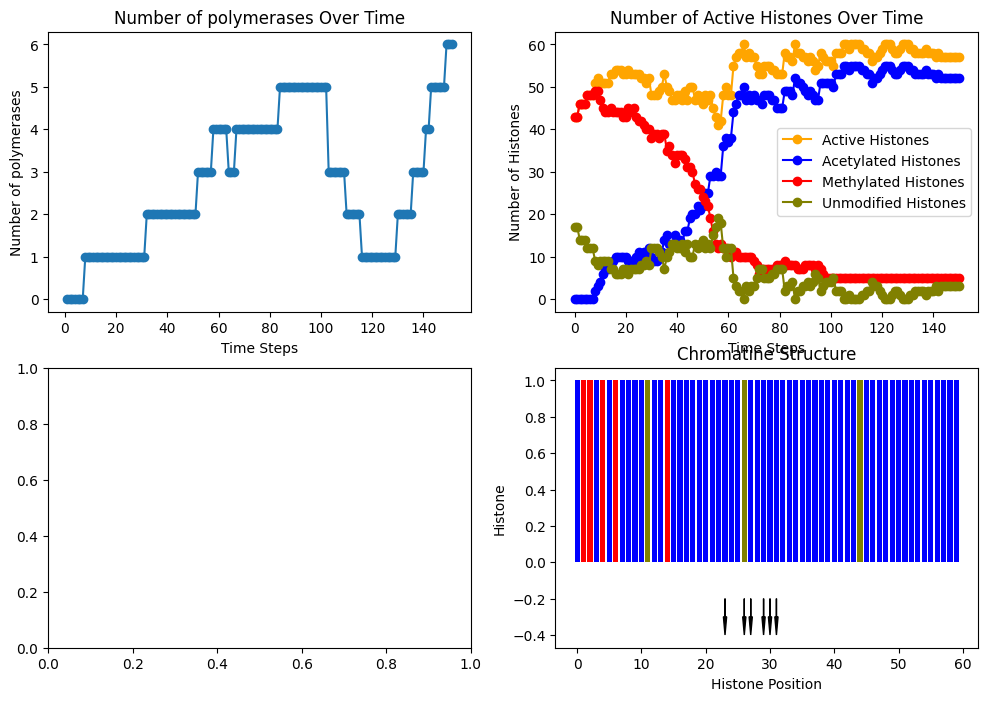

In [9]:

# Create an animated plot
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
ani = FuncAnimation(fig, update, frames=simulation_steps, repeat=False)

# Save the animation as a video (e.g., in mp4 format)
ani.save('animated_3stateschromatine.gif',   writer=PillowWriter(fps=10))

plt.show()



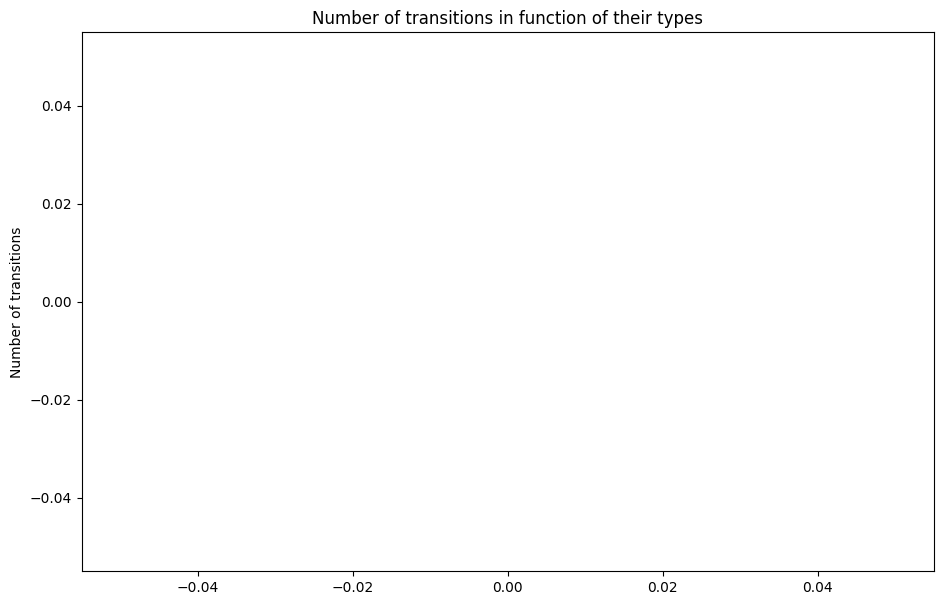

In [5]:
# Display the transitions dictionary after the simulation
fig, ax = plt.subplots(figsize=(11, 7))
plt.bar(transitions_dict.keys(), transitions_dict.values(), color='g')
ax.set_ylabel('Number of transitions')
ax.set_title('Number of transitions in function of their types')
plt.show()